In [114]:
%load_ext autoreload
%autoreload 2

import sys
import yaml
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from Bio import SeqIO
from tqdm import tqdm
from pytorch_lightning import Trainer
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import hamming
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

sys.path.append('..')
sys.path.append('pLMtrainer')
from pLMtrainer.models.frustraSeq import FrustraSeq
from pLMtrainer.dataloader import FrustrationDataModule

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# general info for script

## 1) Load Data
First we load a simple fasta file containing the headers/ids and their sequences and store it in a dictionary of the form {id: sequence}

### TRIZOD

In [2]:
strict_data = {}
with open("../data/trizod/2024-05-09/strict.json", "r") as f:
    fasta_data = f.read()
    for line in fasta_data.splitlines():
        data = json.loads(line)
        strict_data[data["ID"]] = data
strict_data["19347_1_1_1"]["seq"]

'MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGNIAAATGFVKKDQMGKGEEGYPQEGILEDMPVDPGSEAYEMPSEEGYQDYEPEA'

In [3]:
strict_data["19347_1_1_1"].keys()

dict_keys(['ID', 'entryID', 'stID', 'entity_assemID', 'entityID', 'entity_name', 'exp_method', 'exp_method_subtype', 'citation_DOI', 'citation_title', 'ionic_strength', 'pH', 'temperature', 'off_C', 'off_CA', 'off_CB', 'off_H', 'off_HA', 'off_HB', 'off_N', 'bbshift_positions_post', 'bbshift_types_post', 'total_bbshifts', 'seq', 'k', 'zscores', 'gscores'])

In [4]:
df_trizod = pd.DataFrame.from_dict(strict_data, orient='index')
df_trizod.rename(columns={"ID":'id', "seq":'sequence'}, inplace=True)
df_trizod = df_trizod.sample(50, random_state=42).reset_index(drop=True)
df_trizod.head(2)

,id,entryID,stID,entity_assemID,entityID,entity_name,exp_method,exp_method_subtype,citation_DOI,citation_title,...,off_HA,off_HB,off_N,bbshift_positions_post,bbshift_types_post,total_bbshifts,sequence,k,zscores,gscores
0,19366_1_1_1,19366,1,1,1,entity,NMR,SOLUTION,,Structural basis for -10 promoter element melt...,...,0.0,0.0,0.0,101.0,6.0,576.0,MSEQLTDQVLVERVQKGDQKAFNLLVVRYQHKVASLVSRYVPSGDV...,"[0, 0, 6, 12, 18, 18, 18, 18, 18, 18, 18, 18, ...","[None, None, None, 9.5965, 11.0404, 12.7949, 1...","[None, None, None, 0.1406, 0.1772, 0.0871, 0.0..."
1,17509_1_1_1,17509,1,1,1,YP_557733.1,NMR,"NMR, 20 STRUCTURES",,Null,...,0.0,0.0,0.0,143.0,6.0,808.0,IPKHPDSEAVAPDPFNPAATQLLDDTSWVLSAWKQADGTARAVPSA...,"[4, 10, 16, 16, 16, 16, 18, 18, 18, 18, 16, 16...","[None, -0.4922, 0.2746, -0.0068, 0.1071, -1.17...","[None, 0.898, 0.8569, 0.8697, 0.8646, 0.9154, ..."


In [5]:
df_trizod["sequence"].str.len().max()

np.int64(467)

### BONOMI

In [58]:
fasta_file_path = "../data/frustration/bonomi_ensembles_sequences.fasta"

In [59]:
seqs = {}
with open(fasta_file_path, 'r') as f:
    fasta_data = f.read()
    for line in fasta_data.splitlines():
        if line.startswith(">"):
            header = line[1:]
            seqs[header] = ""
        else:
            seqs[header] += line.strip()
seqs

{'Alb3-A3CT': 'MDENASKIISAGRAKRSIAQPDDAGERFRQLKEQEKRSKKNKAVAKDTVELVEESQSESEEGSDDEEEEAREGALASSTTSKPLPEVGQRRSKRSKRKRTV',
 'FCP1': 'PGPEEQEEEPQPRKPGTRRERTLGAPASSERSAAGGRGPRGHKRKLNEEDAASESSRESSNEDEGSSSEADEMAKALEAELNDLM',
 'emerin_67-170': 'GTRGDADMYDLPKKEDALLYQSKGYNDDYYEESYFTTRTYGEPESAGPSRAVRQSVTSFPDADAFHHQVHDDDLLSSSEEECKDRERPMYGRDSAYQSITHYRPV',
 'UBact': 'MIQSLMPERRERPGDPMPKSPSPLEEGGGPRRPETGSPDKDSLLKRMRRVDPKQAERYRQRTGE',
 'Nsp2_CtlIDR': 'KEIIFLEGETLPTEVLTEEVVLKTGDLQPLEQPTSEAVEAPLVGT',
 'NHE1': 'MINNYLTVPAHKLDSPTMSRARIGSDPLAYEPKEDLPVITIDPASPQSPESVDLVNEELKGKVLGLSRDPAKVAEEDEDDDGGIMMRSKETSSPGTDDVFTPAPSDSPSSQRIQRCLSDP',
 'p61_Hck': 'GGRSSCEDPGCPRDEERAPRMGCMKSKFLQVGGNTFSKTETSASPHCPVYVPDPTSTIKPGPNSHNSNTPGIREAGSE',
 'ACTR': 'GTQNRPLLRNSLDDLVGPPSNLEGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPKQD',
 'Hug1': 'AMADPMTMDQGLNPKQFFLDDVVLQDTLCSMSNRVNKSVKTGYLFPKDHVPSANIIAVERRGGLSDIGKNTSN',
 'PaaA2': 'MDYKDDDDKNRALSPMVSEFETIEQENSYNEWLRAKVATSLADPRPAIPHDEVERRMAERFAKMRKERSKQ',
 'Nt-SOCS5': 'RSLRQRLQDTVGLCFPM

In [ ]:
df = pd.DataFrame.from_dict(seqs, orient='index', columns=["sequence"]).reset_index().rename(columns={'index':'id'})

In [62]:
df.head()

,id,sequence
0,Alb3-A3CT,MDENASKIISAGRAKRSIAQPDDAGERFRQLKEQEKRSKKNKAVAK...
1,FCP1,PGPEEQEEEPQPRKPGTRRERTLGAPASSERSAAGGRGPRGHKRKL...
2,emerin_67-170,GTRGDADMYDLPKKEDALLYQSKGYNDDYYEESYFTTRTYGEPESA...
3,UBact,MIQSLMPERRERPGDPMPKSPSPLEEGGGPRRPETGSPDKDSLLKR...
4,Nsp2_CtlIDR,KEIIFLEGETLPTEVLTEEVVLKTGDLQPLEQPTSEAVEAPLVGT


### SPANDRELS

In [5]:
spandrels_fasta = SeqIO.to_dict(SeqIO.parse("../data/frustration/fasta_spandrels_cases/spandrels_all.fasta", "fasta"))
spandrels = {key: str(value.seq) for key, value in spandrels_fasta.items()}

In [6]:
spandrels["Q15382"]

'MPQSKSRKIAILGYRSVGKSSLTIQFVEGQFVDSYDPTIENTFTKLITVNGQEYHLQLVDTAGQDEYSIFPQTYSIDINGYILVYSVTSIKSFEVIKVIHGKLLDMVGKVQIPIMLVGNKKDLHMERVISYEEGKALAESWNAAFLESSAKENQTAVDVFRRIILEAEKMDGAASQGKSSCSVM'

In [12]:
df_spandrels = pd.DataFrame.from_dict(spandrels, orient='index', columns=["sequence"]).reset_index().rename(columns={'index':'id'})
df_spandrels.head(3)

,id,sequence
0,2dn1A,LSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFD...
1,1fhjA,VLSPADKTNIKSTWDKIGGHAGDYGGEALDRTFQSFPTTKTYFPHF...
2,1fsxA,VLSAADKGNVKAAWGKVGGHAAEYGAEALERMFLSFPTTKTYFPHF...


In [13]:
df_spandrels["sequence"].str.len().max()

np.int64(340)

## 2) Load Model
We then load the checkpoint of our trained model and create a dataloader from the dictionary

In [9]:
# load config
with open(f"../data/it5_ABL_protT5_CW/config.yaml", 'r') as f:
    config = yaml.safe_load(f)
config["experiment_name"]

'it5_ABL_protT5_CW'

In [10]:
# either provide path to pretrained model or 
# set to huggingface model name (e.g. "Rostlab/prot_t5_xl_uniref50" for protT5-xl) 
config["pLM_model"] = "Rostlab/prot_t5_xl_uniref50"

In [11]:
model = FrustraSeq.load_from_checkpoint(checkpoint_path=f"../data/{config['experiment_name']}/best_val_model.ckpt",
                                        config=config)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


RANK -1: Model initialized.


In [14]:
predict_dataloader = FrustrationDataModule(df=df_spandrels,
                                            max_seq_length=df_spandrels["sequence"].str.len().max(),
                                            batch_size=10,
                                            num_workers=1,
                                            persistent_workers=True,)

In [15]:
# adding the surprisal dictionary which is used to compute the surprisal feature during inference based on 
# precomputed values (for each aa) from the train set
with open('../data/frustration/reg_heuristic.json', 'r') as f:
    model.surprisal_dict = json.load(f)
model.surprisal_dict["A"]

{'mean': 0.24633155516241328, 'std': 0.5921655729624687}

## 3) Inference

Lets define a Lightning trainer and run inference (prediction)

In [16]:
trainer = Trainer(accelerator='mps',) # use 'gpu' instead of 'mps' on cuda enabled devices or 'cpu' for cpu only

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [17]:
trainer.predict(model, predict_dataloader)

Loaded 89 sequences for prediction.
Created test dataset for prediction
Test dataset size: 89 samples


/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0:  11%|█         | 1/9 [00:16<02:12,  0.06it/s]

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pytorch_lightning/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Predicting DataLoader 0: 100%|██████████| 9/9 [01:49<00:00,  0.08it/s]


[None, None, None, None, None, None, None, None, None]

In [18]:
# model.pred_list contains a list of prediction dictionaries (one per protein)
len(model.pred_list), model.pred_list[0].keys()

(89,
 dict_keys(['residue', 'frustration_index', 'frustration_class', 'entropy', 'surprisal']))

We then can either create protein specific dataframes or one combined one for all protein sequences in the input fasta file.

In [ ]:
#per_protein_df = pd.DataFrame(model.pred_list[0]) # for the first protein
#per_protein_df.head()

,residue,frustration_index,frustration_class,entropy,surprisal
0,M,-0.201939,1,0.969150,-1.526286
1,S,-0.006349,1,0.830865,0.802698
2,E,-0.275595,1,0.950753,0.457506
3,Q,-0.062453,1,0.777766,1.272453
4,L,0.759289,2,0.496933,-0.956506


In [20]:
pred_dfs = []
for pred, id in zip(model.pred_list, df_spandrels["id"]):
    pred["id"] = id
    pred_dfs.append(pd.DataFrame(pred))
combined_df = pd.concat(pred_dfs, ignore_index=True)
combined_df

,residue,frustration_index,frustration_class,entropy,surprisal,id
0,L,0.341463,2,0.922937,-1.980968,2dn1A
1,S,0.026862,1,0.903219,0.873911,2dn1A
2,P,-0.701609,0,0.560852,0.010333,2dn1A
3,A,-0.032252,1,0.974912,-0.470449,2dn1A
4,D,-0.890091,0,0.448243,-0.408910,2dn1A
...,...,...,...,...,...,...
18712,R,-0.408225,1,0.847325,-0.430148,P11234
18713,C,1.747608,2,0.114289,0.256336,P11234
18714,C,1.434457,2,0.298438,-0.193654,P11234
18715,L,0.853980,2,0.466865,-0.724333,P11234


In [21]:
# saving the results to csv files if wanted.
#per_protein_df.to_csv("./bonomi_protein1_predictions.csv", index=False)
combined_df.to_csv("../data/frustration/spandrels_all_proteins_predictions.csv", index=False)

## 4) Analysis

In [58]:
test_data = np.load("../data/it5_ABL_protT5_CW/test_preds.npz")

In [59]:
test_data.keys()

KeysView(NpzFile '../data/it5_ABL_protT5_CW/test_preds.npz' with keys: full_seqs, masks, regr_preds, cls_preds, regr_targets...)

In [60]:
test_data["regr_preds"].shape, test_data["regr_targets"].shape

((47765, 512), (47765, 512))

In [116]:
hamming(test_data["cls_targets"][0], test_data["cls_preds"][0])

np.float64(0.513671875)

In [61]:
coss = cosine_similarity(test_data["regr_targets"], test_data["regr_preds"])

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [62]:
# extract only the diagonal
coss_diag = np.diag(coss)
coss_diag.shape

(47765,)

In [ ]:
max_seq_length = test_data["regr_preds"].shape[1]
padded_seqs = []
for seq in test_data["full_seqs"]:
    if len(seq) < max_seq_length:
        # Pad the sequence
        padding = "X" * (max_seq_length - len(seq))
        padded_seqs.append(seq + padding)
    else:
        # Truncate the sequence
        padded_seqs.append(seq[:max_seq_length])
padded_seqs = np.array(padded_seqs)
seq_array = np.array([list(seq) for seq in padded_seqs])

array(['S', 'S', 'T', ..., 'H', 'K', 'H'], shape=(9736349,), dtype='<U1')

In [89]:
len(residue[0]), len(frst_idx[0]), len(frst_class[0]), len(frst_idx_pred[0]), len(frst_class_pred[0])

(318, 318, 318, 318, 318)

In [96]:
parquet_path = "../data/frustration/v8_frustration_v2.parquet.gzip"
df = pq.read_table(parquet_path).to_pandas()

In [97]:
df = df.loc[df['split_test'] == "test"].copy()

In [119]:
residue = []
frst_idx = []
frst_class = []
frst_idx_pred = []
frst_class_pred = []
cos_sim = []
hamming_dist = []
for seq, mask, regr_target, cls_target, regr_pred, cls_pred, cos in tqdm(zip(seq_array, test_data["masks"], test_data["regr_targets"], test_data["cls_targets"],
                  test_data["regr_preds"], test_data["cls_preds"], coss_diag), total=len(seq_array)):

    residue.append(seq[mask])
    frst_idx.append(regr_target[mask])
    frst_class.append(cls_target[mask])
    frst_idx_pred.append(regr_pred[mask])
    frst_class_pred.append(cls_pred[mask])
    cos_sim.append(cos)
    hamming_dist.append(hamming(cls_target[mask], cls_pred[mask]))

  0%|          | 0/47765 [00:00<?, ?it/s]/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 47765/47765 [00:00<00:00, 78289.19it/s]


In [120]:
df_results = pd.DataFrame({
    "protein_id": df["proteinID"],
    "residue": residue,
    "frst_idx": frst_idx,
    "frst_class": frst_class,
    "frst_idx_pred": frst_idx_pred,
    "frst_class_pred": frst_class_pred,
    "cos_sim": cos_sim,
    "hamming_dist": hamming_dist,
})
df_results

,protein_id,residue,frst_idx,frst_class,frst_idx_pred,frst_class_pred,cos_sim,hamming_dist
18,1gq8A00,"[S, S, T, V, G, P, N, V, V, V, A, A, D, G, S, ...","[0.2, -0.313, -0.224, 1.238, -0.518, -1.235, -...","[1, 1, 1, 2, 1, 0, 0, 2, 2, 2, 1, 1, 2, 1, 1, ...","[0.004722774, -0.017667048, 0.1479392, 0.92828...","[1, 1, 1, 2, 1, 0, 0, 2, 2, 2, 1, 1, 0, 1, 1, ...",0.834309,0.216981
20,1hc7D01,"[K, G, L, T, P, Q, S, Q, D, F, S, E, W, Y, L, ...","[-0.689, 0.279, 0.489, -0.039, 0.115, -1.054, ...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1, 2, ...","[0.045429535, -0.25762632, 0.44539, 0.22242832...","[0, 1, 2, 1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 2, ...",0.591614,0.275093
46,1qz9A02,"[P, V, A, A, L, A, R, A, Q, A, V, I, A, E, E, ...","[-1.405, 0.561, -0.096, 0.065, 1.2, 0.509, -0....","[0, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, ...","[-1.0342952, 1.3697134, 0.18977958, 0.479766, ...","[0, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, ...",0.677122,0.222222
52,1t8bB01,"[M, K, L, F, K, E, L, E, E, T, K, E, Q, V, I, ...","[0.162, -0.576, 1.141, -0.862, 1.385, -0.463, ...","[1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, ...","[0.21832126, -0.5834592, 0.71002555, 0.4802951...","[2, 0, 2, 2, 0, 0, 2, 2, 1, 1, 0, 0, 1, 2, 2, ...",0.605486,0.315315
68,1xg2A00,"[I, I, A, N, A, V, V, A, Q, D, G, T, G, D, Y, ...","[1.7, 1.412, 0.399, -0.844, 0.736, 1.374, 1.43...","[2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, ...","[0.4538526, 0.6312163, 0.59751433, -0.99335545...","[2, 2, 2, 0, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 2, ...",0.831840,0.274448
...,...,...,...,...,...,...,...,...
983088,AF-X8JBN5-F1-model_v4_TED01,"[D, S, F, I, A, S, E, S, P, I, A, K, A, G, V, ...","[-0.869, -0.236, 1.321, 1.222, -0.136, 0.194, ...","[1, 1, 2, 2, 1, 1, 0, 1, 0, 2, 1, 0, 2, 1, 2, ...","[-0.7654841, -0.37426987, 0.7508077, 1.3608493...","[0, 1, 2, 2, 1, 1, 0, 1, 0, 2, 2, 0, 2, 1, 2, ...",0.793060,0.242925
983113,AF-X8JM27-F1-model_v4_TED01,"[E, D, Y, Q, K, V, Y, N, R, I, A, E, I, L, D, ...","[0.7, 0.069, -0.472, -0.257, 0.331, 1.41, 0.98...","[2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, ...","[0.6092909, -0.029569685, 0.41230005, -0.31276...","[2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 0, 2, 2, 0, ...",0.475294,0.318182
983119,AF-X8JMY5-F1-model_v4_TED02,"[K, E, L, I, E, A, E, Q, I, V, R, D, D, E, Q, ...","[-0.336, -0.59, 0.331, -0.704, -0.153, 0.976, ...","[1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, ...","[-0.6864968, -0.99286443, 1.2163503, 0.9941579...","[0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 1, 0, 0, 2, 1, ...",0.348861,0.396552
983142,AF-X8JRL9-F1-model_v4_TED01,"[A, T, K, L, L, H, A, D, D, E, A, H, S, E, A, ...","[0.523, -0.245, -0.884, 1.247, 1.52, 0.608, -0...","[1, 1, 1, 2, 2, 2, 1, 0, 1, 1, 2, 1, 1, 0, 0, ...","[-0.048715338, -0.07291347, -0.97762483, 1.050...","[1, 1, 0, 2, 2, 1, 1, 0, 0, 0, 0, 2, 1, 0, 1, ...",0.649062,0.245833


In [121]:
df_results.to_parquet("../data/frustration/test_set_predictions_and_cos_similarity.parquet.gzip", index=False)

In [122]:
df_read = pq.read_table("../data/frustration/test_set_predictions_and_cos_similarity.parquet.gzip").to_pandas()
df_read

,protein_id,residue,frst_idx,frst_class,frst_idx_pred,frst_class_pred,cos_sim,hamming_dist
0,1gq8A00,"[S, S, T, V, G, P, N, V, V, V, A, A, D, G, S, ...","[0.2, -0.313, -0.224, 1.238, -0.518, -1.235, -...","[1, 1, 1, 2, 1, 0, 0, 2, 2, 2, 1, 1, 2, 1, 1, ...","[0.004722774, -0.017667048, 0.1479392, 0.92828...","[1, 1, 1, 2, 1, 0, 0, 2, 2, 2, 1, 1, 0, 1, 1, ...",0.834309,0.216981
1,1hc7D01,"[K, G, L, T, P, Q, S, Q, D, F, S, E, W, Y, L, ...","[-0.689, 0.279, 0.489, -0.039, 0.115, -1.054, ...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1, 2, ...","[0.045429535, -0.25762632, 0.44539, 0.22242832...","[0, 1, 2, 1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 2, ...",0.591614,0.275093
2,1qz9A02,"[P, V, A, A, L, A, R, A, Q, A, V, I, A, E, E, ...","[-1.405, 0.561, -0.096, 0.065, 1.2, 0.509, -0....","[0, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, ...","[-1.0342952, 1.3697134, 0.18977958, 0.479766, ...","[0, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, ...",0.677122,0.222222
3,1t8bB01,"[M, K, L, F, K, E, L, E, E, T, K, E, Q, V, I, ...","[0.162, -0.576, 1.141, -0.862, 1.385, -0.463, ...","[1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, ...","[0.21832126, -0.5834592, 0.71002555, 0.4802951...","[2, 0, 2, 2, 0, 0, 2, 2, 1, 1, 0, 0, 1, 2, 2, ...",0.605486,0.315315
4,1xg2A00,"[I, I, A, N, A, V, V, A, Q, D, G, T, G, D, Y, ...","[1.7, 1.412, 0.399, -0.844, 0.736, 1.374, 1.43...","[2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, ...","[0.4538526, 0.6312163, 0.59751433, -0.99335545...","[2, 2, 2, 0, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 2, ...",0.831840,0.274448
...,...,...,...,...,...,...,...,...
47760,AF-X8JBN5-F1-model_v4_TED01,"[D, S, F, I, A, S, E, S, P, I, A, K, A, G, V, ...","[-0.869, -0.236, 1.321, 1.222, -0.136, 0.194, ...","[1, 1, 2, 2, 1, 1, 0, 1, 0, 2, 1, 0, 2, 1, 2, ...","[-0.7654841, -0.37426987, 0.7508077, 1.3608493...","[0, 1, 2, 2, 1, 1, 0, 1, 0, 2, 2, 0, 2, 1, 2, ...",0.793060,0.242925
47761,AF-X8JM27-F1-model_v4_TED01,"[E, D, Y, Q, K, V, Y, N, R, I, A, E, I, L, D, ...","[0.7, 0.069, -0.472, -0.257, 0.331, 1.41, 0.98...","[2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, ...","[0.6092909, -0.029569685, 0.41230005, -0.31276...","[2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 0, 2, 2, 0, ...",0.475294,0.318182
47762,AF-X8JMY5-F1-model_v4_TED02,"[K, E, L, I, E, A, E, Q, I, V, R, D, D, E, Q, ...","[-0.336, -0.59, 0.331, -0.704, -0.153, 0.976, ...","[1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, ...","[-0.6864968, -0.99286443, 1.2163503, 0.9941579...","[0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 1, 0, 0, 2, 1, ...",0.348861,0.396552
47763,AF-X8JRL9-F1-model_v4_TED01,"[A, T, K, L, L, H, A, D, D, E, A, H, S, E, A, ...","[0.523, -0.245, -0.884, 1.247, 1.52, 0.608, -0...","[1, 1, 1, 2, 2, 2, 1, 0, 1, 1, 2, 1, 1, 0, 0, ...","[-0.048715338, -0.07291347, -0.97762483, 1.050...","[1, 1, 0, 2, 2, 1, 1, 0, 0, 0, 0, 2, 1, 0, 1, ...",0.649062,0.245833


In [128]:
spearmanr(df_results['cos_sim'].values[:10], df_results['hamming_dist'].values[:10])

SignificanceResult(statistic=np.float64(-0.32121212121212117), pvalue=np.float64(0.3654683104386702))

In [131]:
df_results['hamming_dist']

18        0.216981
20        0.275093
46        0.222222
52        0.315315
68        0.274448
            ...   
983088    0.242925
983113    0.318182
983119    0.396552
983142    0.245833
983198    0.338542
Name: hamming_dist, Length: 47765, dtype: float64

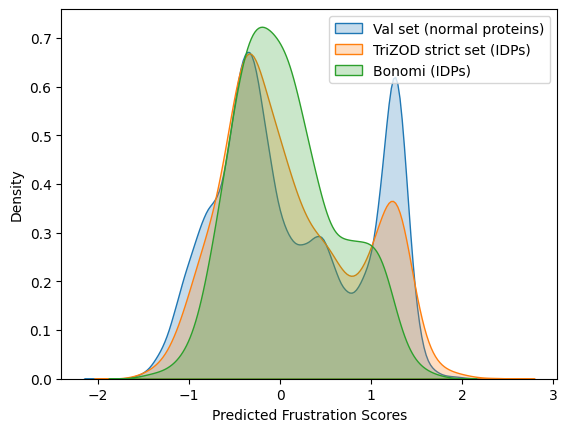

In [95]:
sns.kdeplot(val_data["masked_regr_preds"], 
            fill=True, label="Val set (normal proteins)")
sns.kdeplot(combined_df["frustration_index"], fill=True, label="TriZOD strict set (IDPs)")
sns.kdeplot(combined_df_G["frustration_index"], fill=True, label="Bonomi (IDPs)")
plt.xlabel("Predicted Frustration Scores")
plt.legend()
plt.show()

In [94]:
np.bincount(val_data["masked_cls_preds"]) / len(val_data["masked_cls_preds"])

array([0.24310913, 0.37306076, 0.38383011])

In [90]:
combined_df["frustration_class"].value_counts() / len(combined_df)

frustration_class
1    0.399935
2    0.349372
0    0.250693
Name: count, dtype: float64

In [82]:
combined_df_G["frustration_class"].value_counts() / len(combined_df_G)

frustration_class
1    0.430815
2    0.307405
0    0.261780
Name: count, dtype: float64